# Thinking about visiting seattle on a budget? Here's a few tips.

In this notebook I will explore these three questions:
#### 1. What's the cheapest month to do so?
#### 2. Are the prices related with the number of available listings?
#### 3. Do cheaper listings have lower ratings or not necessarily?

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

## Loading data

In [2]:
seattle_calendar = pd.read_csv('./seattle_airbnb_data/calendar.csv')
seattle_listings = pd.read_csv('./seattle_airbnb_data/listings.csv')

## Exploring data

In [3]:
seattle_calendar.head(5)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


## Extracting month column

In [4]:
def getMonth(x):
    '''
    Inputs:
        x: date in "%Y-%m-%d" format
    
    Returns:
        month
    '''
    
    return datetime.datetime.strptime(x, "%Y-%m-%d").month

seattle_calendar['month'] = seattle_calendar['date'].apply(lambda x: getMonth(x))
seattle_calendar.head()

,listing_id,date,available,price,month
0,241032,2016-01-04,t,$85.00,1
1,241032,2016-01-05,t,$85.00,1
2,241032,2016-01-06,f,NaN,1
3,241032,2016-01-07,f,NaN,1
4,241032,2016-01-08,f,NaN,1


## Checking for missing values

In [5]:
seattle_calendar.isnull().sum()

listing_id         0
date               0
available          0
price         459028
month              0
dtype: int64

### Well, there are only NaNs in the price column, let's see if we should just drop them by calculating their percentage of the total dataset

In [6]:
seattle_calendar['price'].isna().sum()/seattle_calendar.shape[0]

0.32938998399793334

**That's 32.9% percent of our dataset, quite alot, we shouldn't just drop them.**

## The price is string, we will convert it to float to be able to perform operations and fill those NaNs with each months' mean price

In [7]:
# converting $85.00 to float 85.00
seattle_calendar['price'] = seattle_calendar['price'].str.replace(',', '')
seattle_calendar['price'] = seattle_calendar['price'].str.replace('$', '').astype('float')

# filling NaNs 
seattle_calendar['price'] = seattle_calendar.groupby('month')['price'].transform(lambda x: x.fillna(x.mean()))

seattle_calendar.head()

,listing_id,date,available,price,month
0,241032,2016-01-04,t,85.000000,1
1,241032,2016-01-05,t,85.000000,1
2,241032,2016-01-06,f,122.912176,1
3,241032,2016-01-07,f,122.912176,1
4,241032,2016-01-08,f,122.912176,1


In [8]:
seattle_calendar.isnull().sum()

listing_id    0
date          0
available     0
price         0
month         0
dtype: int64

**We are now NaNs-free!**

## Some useful statisitics about our data

In [9]:
seattle_calendar.describe()

,listing_id,price,month
count,1.393570e+06,1.393570e+06,1.393570e+06
mean,5.550111e+06,1.379153e+02,6.528767e+00
std,2.962274e+06,8.621109e+01,3.443855e+00
min,3.335000e+03,1.000000e+01,1.000000e+00
25%,3.258213e+06,9.000000e+01,4.000000e+00
50%,6.118244e+06,1.286445e+02,7.000000e+00
75%,8.035212e+06,1.500000e+02,1.000000e+01
max,1.034016e+07,1.650000e+03,1.200000e+01


## Q1: What's the cheapest month to do visit seattle?

In [10]:
# grouping data to get price_per_month
price_per_month = seattle_calendar.groupby(['month'])['price'].mean().values.tolist()

# months
months = seattle_calendar['month'].unique().tolist()

Text(0.5, 1.0, 'Average price per month')

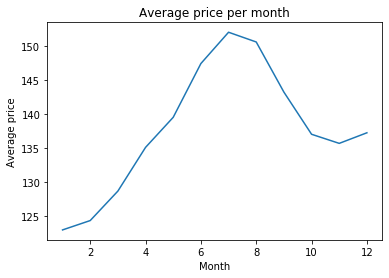

In [11]:
plt.plot(months, price_per_month)
plt.xlabel('Month')
plt.ylabel('Average price')
plt.title('Average price per month')

**It seems like January is the cheapest month, it may be because of the school season, but we can't be sure.**

**We can see that prices gradually increase until it peaks at over 150 in July, then falls again till November.**

## Q2: Are the prices related with the number of available listings in that month?

**Let's see...**

In [12]:
# getting number of available listings per month
available_per_month = seattle_calendar.groupby(['available','month'])['listing_id'].count().unstack().drop('f', axis=0)

In [13]:
available_per_month

month,1,2,3,4,5,6,7,8,9,10,11,12
available,,,,,,,,,,,,
t,64937,73321,83938,76037,79971,77244,74222,76347,77246,82438,81780,87061


In [14]:
available_listings = available_per_month.values.tolist()[0]

Text(0.5, 1.0, 'Available listings per month')

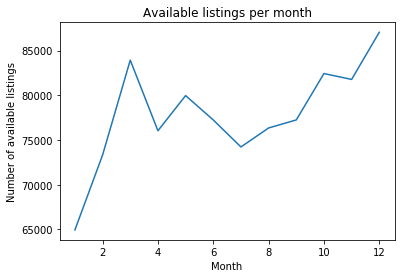

In [15]:
plt.plot(months, available_listings)
plt.xlabel('Month')
plt.ylabel('Number of available listings')
plt.title('Available listings per month')

**This seems affecting the prices abit as the prices went up in the period of 4:7 which has a decrease in the number of available listings, but mostly, it doesn't really seem true because the least number of listings was in January and it had the lowest average price.**

## Q3: Do cheaper listings have lower ratings or not necessarily?

In [16]:
# getting scores_values and ids
seattle_review_values = seattle_listings[['review_scores_value', 'id']]

# merging it with the price
review_price_values = seattle_calendar.merge(seattle_review_values, left_on='listing_id', right_on='id')

# drop extra id column
review_price_values.drop('id', axis=1, inplace=True)

In [17]:
review_price_values.head()

,listing_id,date,available,price,month,review_scores_value
0,241032,2016-01-04,t,85.000000,1,10.0
1,241032,2016-01-05,t,85.000000,1,10.0
2,241032,2016-01-06,f,122.912176,1,10.0
3,241032,2016-01-07,f,122.912176,1,10.0
4,241032,2016-01-08,f,122.912176,1,10.0


In [18]:
# getting average price per score_value
average_price = review_price_values.groupby(['review_scores_value'])['price'].mean().values.tolist()

# geting reviews values
review = review_price_values.groupby(['review_scores_value'])['price'].mean().index.tolist()

Text(0.5, 1.0, 'price per rating')

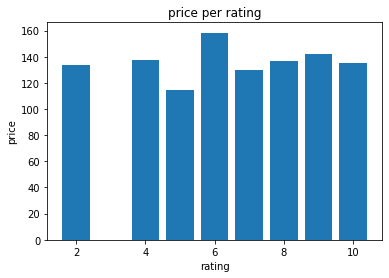

In [19]:
plt.bar(review, average_price)
plt.xlabel('rating')
plt.ylabel('price')
plt.title('price per rating')

**We can see that the highest average prices have medium rating of 6, while less expensive listings from 130:140 ranged from 7 to 10.**

**So, price isn't affected by reviews, because the average price of the listings rated 2 was about 135, and it's not necessarily tha cheaper listings have lower ratings.**